# Sonic log - Dalbyover 59.459  

Reading LAS wireline log file, calculate sonic velocity from arrival times. 
 
The tool used for sonic logs havce recievers at 0.60, 0.80 and 1.00m according to [factsheet](https://github.com/TobbeTripitaka/Dalbyover/blob/master/Sonic-slimhole_TRGS8068.pdf). The header of the [LAS files](https://github.com/TobbeTripitaka/Dalbyover/tree/master/data) states that the measurements are in _m_ and _km_. Modified sonic log used.  

The upper 40m, the most interesting depths fo us, is unfortunately missing. The well needed a steel casting to not collaps and sonic logs are not correct. 

In [14]:
#Plot in document
%matplotlib inline

In [15]:
import numpy as np
import pandas as pd
import numpy.lib.recfunctions
import matplotlib.pyplot as plt
import scipy.signal as signal
      
def read_LAS(file_name,file_header=33):
    '''
    Read LAS file from Robertson Geologging WinLogger
    Specify file name and header line nr.  
    '''
    in_file_A = pd.read_csv(file_name, header=file_header,delim_whitespace=True, 
                          na_values=['1.#J',0,-999.25,-999999.00000])
    
    # LAS files have an extra carachter that adds an extra column
    in_file = in_file_A[in_file_A.columns[:-1]]
    in_file.columns = in_file_A.columns[1:]
    in_file=in_file.dropna(axis=1,how='all')
    in_file[in_file < min_value] = np.nan
    return in_file

# In files 
in_sonic = 'data/59-459_Sonic3_Final04.LAS'
in_electric = ['data/TCDS3719-Dalbyover1.LAS', 'data/TCDS3719-Dalbyover2.LAS']
in_gamma = 'data/INDG1832-Dalbyover3.LAS'
#Old sonic logs: 'data/TRGS8068-Dalbyover5.LAS', 'data/TRGS8068-Dalbyover4.LAS'
#sonic = pd.concat([read_LAS(in_sonic[1],38), read_LAS(in_sonic[0],38)])

#Crop out negative values
min_value = -1

# Read and merge sonic logs
sonic = read_LAS(in_sonic,46)
sonic.columns = ['DEPTH', 'TXRX1','TXRX2','TXRX3','R1R2','R2R3','R1R3','SONIC','NGTR','NANA']

# Read and join electric logs
electric = pd.merge(read_LAS(in_electric[0]), read_LAS(in_electric[1]), 
                    on='DEPTH', how='outer',suffixes=('_E1', '_E2'))

# Read gamma log
#gamma = read_LAS(in_gamma,32)

# Merge all data on depth
data = pd.merge(electric, sonic, on='DEPTH', how='outer',indicator='indicator_column')
data.sort_values('DEPTH', ascending=True)

# Save a file with sonic and electric data
data.to_csv('log_data.txt')

print data.describe()
#print data.head()

              DEPTH       NGAM_E1       COND_E1       TEMP_E1       TEMP_E2  \
count  34894.000000  34586.000000  34557.000000  34561.000000  34605.000000   
mean     174.284995      8.890979    357.003930     10.499044     11.119097   
std      100.731754      4.674639    131.607944      1.630407      1.786431   
min       -0.190000      1.330000     10.860000      7.270000      8.380000   
25%       87.052500      6.100000    379.980000      8.770000      9.470000   
50%      174.285000      7.960000    401.860000     10.340000     11.130000   
75%      261.517500     10.340000    418.920000     12.020000     12.620000   
max      348.750000     67.800000   1604.930000     13.380000     14.600000   

            COND_E2       NGAM_E2         TXRX1         TXRX2         TXRX3  \
count  34610.000000  34626.000000  30082.000000  30078.000000  30068.000000   
mean   17650.050734     11.360126    282.521033    370.996125    459.006274   
std    15581.057039      5.590867     20.571478    

Plots of velocities from R2-R1 and R3-R2. R3-R1 is commented out for clarity. 

To fix:
Make calculated velocities and show with tools velocities
Calculate a feu exemples
Inspect data
Plot gamma logs and differences/variations
Make functions for plotting
Print dtype for data array
water mud curve with pressure and maybe salinity 
Archie's law
Black box on top

In [16]:
# Try scaling of velocity. Try e.g. 0.3048, meters to feet.
C = 1

# M s to us
M = 10**6 

# Calculate velocity from spacing (20cm) and arrival time difference
np.seterr(divide='ignore')
v1 = M*0.2/(data['TXRX2']-data['TXRX1'])
v2 = M*0.2/(data['TXRX3']-data['TXRX2'])

#print v1.describe()

# Calculate a few exemples

sample_depths = [10.2,20.,100.,300]
sample_depths.sort()

for sample in sample_depths:
    sample_data = data.loc[data['DEPTH'] == sample]
    v1 = M*0.20/(sample_data['TXRX2']-sample_data['TXRX1']) #R2-R1
    v2 = M*0.20/(sample_data['TXRX3']-sample_data['TXRX2']) #R3-R2
    print 'v at %.2fm is %f (R2-R1) and %f (R3-R2).' % (sample,v1,v2)


v at 10.20m is nan (R2-R1) and nan (R3-R2).
v at 20.00m is nan (R2-R1) and nan (R3-R2).
v at 100.00m is 2243.158367 (R2-R1) and 2465.483235 (R3-R2).
v at 300.00m is 2536.783359 (R2-R1) and 2396.931927 (R3-R2).


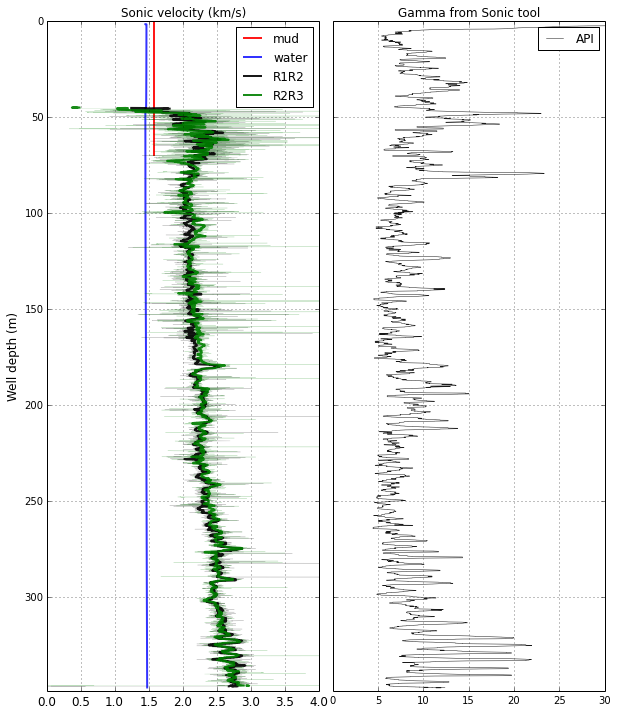

In [17]:
# Plot sonic

def well_plot(x,y=data['DEPTH'],label=None,lw=1,color='black',alpha=0.9):
    '''
    Using matplotlib to plot a well log. 
    '''
    plt.plot(x,y,label = label,lw = lw, color=color, alpha=alpha)
    plt.ylim(max(data['DEPTH']),0)
    return

def smooth_filter(raw,kernel=51):
    '''
    Apply median filter, set window size. Must be odd number. 
    '''
    return signal.medfilt(raw, kernel_size=kernel)


# Apply smoothing filter kernel is median window size, must be odd
kernel=99

fig = plt.figure(figsize=(10,12))
fig.subplots_adjust(wspace=0.05)

ax1 = plt.subplot(121)
ax1.set_ylim(ax1.get_ylim()[::-1]) 
plt.title('Sonic velocity (km/s)', fontsize = 12)
plt.ylabel('Well depth (m)', fontsize = 12)

#Plot mud velocity 5,300 feet/s
avg_temp = 0.5*(data['TEMP_E1']+data['TEMP_E2'])
plt.axvline(x=1.581, color='red', label='mud',lw=2,alpha=0.9,ymin=0.8)
plt.plot((1404.3+4.7*avg_temp+0.04*avg_temp**2)/1000,data['DEPTH'], lw=2, color='blue', label='water', alpha=0.8)

#well_plot(C*data['R1R2'],data['DEPTH']+0.1,'TEST!')

#def well_plot(x,y=data['DEPTH'],well_label='x',well_lw=1,well_color='black',well_alpha=0.9):


#Plot raw data
well_plot(data['R1R2'],data['DEPTH']+0.1, lw=0.3, alpha=0.3)
well_plot(data['R2R3'],data['DEPTH']-0.1, lw=0.3, color='green', alpha=0.3)
#R1R3

#Plot filtered data
well_plot(smooth_filter(C*data['R1R2'],kernel),data['DEPTH']+0.1, 
          label = 'R1R2',lw=2)
well_plot(smooth_filter(C*data['R2R3'],kernel),data['DEPTH']-0.1, 
          label = 'R2R3',lw=2, color='green')


plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.xlim(0, 4)
plt.grid()
plt.legend()

# Plot gamma
ax2 = plt.subplot(122, sharey=ax1)
plt.title('Gamma from Sonic tool', fontsize = 12)
well_plot(smooth_filter(data['NGAM_E1'],101), lw=0.5, label='API')
plt.xlim(0, 30)
plt.ylim(max(data['DEPTH']),0)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.grid()
plt.legend()

plt.show()

Sonic velocities in drill mud is in the range of 185-189 $\mu/ ft$. See [Petrowiki](http://petrowiki.org/Porosity_evaluation_with_acoustic_logging). The lower value is typical for salt mud and showed as a red line in sonic plot. Also velocity for [water](http://www.sciencedirect.com/science/article/pii/S030156299800091X) at about 10 degrees is plotted in blue. 
The velocities for the upper section are very close to these values. As very low velocities are expected in the chalk, the measured signal might actually be from the mud. 

## Conductivity
TCDS3719-Dalbyover1.LAS and TCDS3719-Dalbyover2.LAS contains conductivity, temperature and gamma logs. 

A closer look at the gamma logs:

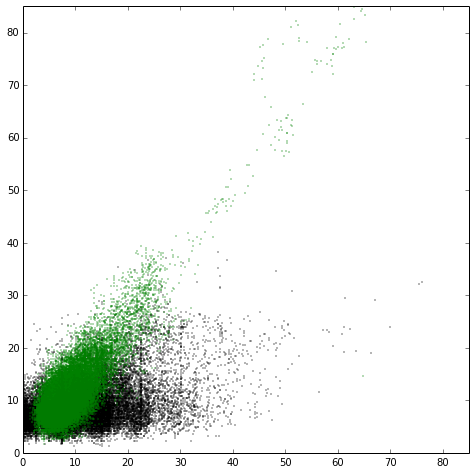

In [19]:
fig = plt.figure(figsize=(8,8))
plt.plot(data['NGTR'],data['NGAM_E1'], 'k.', alpha = 0.3, markersize=3)
plt.plot(data['NGAM_E1'],data['NGAM_E2'], 'g.', alpha = 0.3, markersize=3)
plt.xlim(0,85)
plt.ylim(0,85)
plt.show()

It apears that there is a good correlance between the electric logs, but not between electric and sonic log, especially for lower values. 

Better analysis to come. 

Archie's law links electrical conductivity to porosity and brine saturation. 

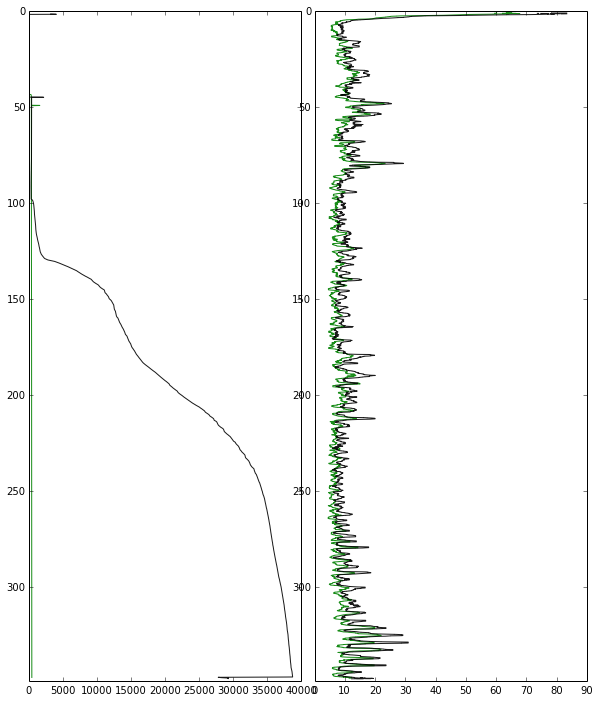

In [100]:
fig = plt.figure(figsize=(10,12))
fig.subplots_adjust(wspace=0.05)

ax1 = plt.subplot(121)
well_plot(data['COND_E1'],color = 'green')
well_plot(data['COND_E2'])

ax2 = plt.subplot(122)
well_plot(smooth_filter(data['NGAM_E2'],101))


plt.show()

1.7774999999999999